# Music generation Using Deep Learning  
### Machine Learning course Project  

This is the project or the machine learning course at UL FRI in semester 1 2022/23.
The aim of this project is to take MIDI files and train a deep neural network to generate MIDI files of new music.
The main paper I am taking inspiration from is "This time with feeling: learning expressive musical performance" by Oore et. al, published online on 2018: https://doi.org/10.1007/s00521-018-3758-9.  

This has several sections.
First there is some data exploration, then model building, then training and then generating and saving new MIDI files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sys; sys.path.append(".")
import os
import mido
import random

In [2]:
# set random seeds for reproducability
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

## The Data  
International Piano-e-Competition™ (https://piano-e-competition.com/default.asp), is a competition where played on a disklavier, which is a real piano that simultaneously records what is played as MIDI data.
The MIDI files are made freely available online (more specifically I obtained them from this github repository https://github.com/studioph/international-e-piano-dataset).

This section is about analysing, exploring and preprocessing this data to be used in subsequent sections.

In [3]:
test_file = mido.MidiFile("midi/ADIG01.mid")
test_file

MidiFile(type=0, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('sequencer_specific', data=(67, 113, 0, 0, 0, 67), time=0),
    MetaMessage('sequencer_specific', data=(67, 113, 0, 1, 0, 1, 0, 83, 111, 110, 97, 116, 97, 32, 105, 110, 32, 70, 32, 32, 32, 32, 32, 77, 46, 32, 65, 100, 105, 103, 101, 122, 97, 108, 122, 97, 100, 101, 32), time=0),
    MetaMessage('sequencer_specific', data=(67, 123, 12, 0, 1), time=0),
    MetaMessage('set_tempo', tempo=512820, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    Message('sysex', data=(126, 127, 9, 1), time=0),
    Message('sysex', data=(67, 16, 76, 0, 0, 126, 0), time=1),
    Message('control_change', channel=0, control=0, value=0, time=4),
    Message('control_change', channel=0, control=32, value=0, time=1),
    Message('program_change', channel=0, program=0, time=1),
    Message('control_change', channel=0, control=7, value=100, time=1),
    Me

In [4]:
np.unique([x.type for x in test_file.tracks[0]])

array(['control_change', 'end_of_track', 'note_on', 'polytouch',
       'program_change', 'sequencer_specific', 'set_tempo', 'sysex',
       'time_signature'], dtype='<U18')

In [5]:
test_file.tracks[0][150:165]

MidiTrack([
  Message('control_change', channel=0, control=64, value=47, time=3),
  Message('control_change', channel=0, control=64, value=0, time=36),
  Message('note_on', channel=0, note=69, velocity=74, time=3),
  Message('note_on', channel=0, note=65, velocity=60, time=12),
  Message('note_on', channel=0, note=41, velocity=60, time=1),
  Message('polytouch', channel=0, note=73, value=127, time=18),
  Message('polytouch', channel=0, note=73, value=0, time=34),
  Message('note_on', channel=0, note=70, velocity=70, time=258),
  Message('note_on', channel=0, note=50, velocity=57, time=18),
  Message('note_on', channel=0, note=41, velocity=0, time=15),
  Message('note_on', channel=0, note=69, velocity=0, time=33),
  Message('polytouch', channel=0, note=50, value=22, time=240),
  Message('note_on', channel=0, note=74, velocity=66, time=2),
  Message('note_on', channel=0, note=50, velocity=0, time=3),
  Message('note_on', channel=0, note=46, velocity=53, time=13)])

In [6]:
for message in test_file.tracks[0]:
    if message.time == 10 and message.type in ["note_on", "note_off"]:
        print(message, message.note)

note_on channel=0 note=53 velocity=52 time=10 53
note_on channel=0 note=58 velocity=52 time=10 58
note_on channel=0 note=65 velocity=0 time=10 65
note_on channel=0 note=69 velocity=0 time=10 69
note_on channel=0 note=69 velocity=65 time=10 69
note_on channel=0 note=65 velocity=60 time=10 65
note_on channel=0 note=69 velocity=66 time=10 69
note_on channel=0 note=65 velocity=58 time=10 65
note_on channel=0 note=65 velocity=69 time=10 65
note_on channel=0 note=65 velocity=0 time=10 65
note_on channel=0 note=61 velocity=86 time=10 61
note_on channel=0 note=69 velocity=77 time=10 69
note_on channel=0 note=53 velocity=68 time=10 53
note_on channel=0 note=79 velocity=0 time=10 79
note_on channel=0 note=76 velocity=78 time=10 76
note_on channel=0 note=74 velocity=0 time=10 74
note_on channel=0 note=57 velocity=66 time=10 57
note_on channel=0 note=59 velocity=75 time=10 59
note_on channel=0 note=56 velocity=69 time=10 56
note_on channel=0 note=74 velocity=0 time=10 74
note_on channel=0 note=59 

In [7]:
print(test_file.ticks_per_beat, test_file.ticks_per_beat*30/4)

480 3600.0


In [8]:
print("type:" + str(test_file.type), "; num. tracks: " + str(len(test_file.tracks)), " ; ", str(test_file.length) + " seconds", "; ", str(len(test_file.tracks[0])) + "messages")
    

type:0 ; num. tracks: 1  ;  261.4196103749941 seconds ;  7874messages


In [9]:
midi_dir = os.listdir("midi/")
print(f'{len(midi_dir)} files')

2431 files


## The Model  
Using Keras (from the tensorflow library), we can build a model with a few lines of code.
In the reference paper by Oore et. al they used a model with an input layer that takes a one-hot 413-dimensional vector, then has three hidden LSTM layers with 512 cells each, then followed by an output layer, which is similar to the input layer.

Following keras documentation: https://keras.io/api/models/model/  
and: https://keras.io/examples/nlp/lstm_seq2seq/

In [10]:
# define input shape: 128 note-on events; 128 note-off events;
# The reference paper also included 125 time-shift events and 32 velocity events, however I am using a simplified model
input_size = 128 + 128 + 125 + 32
num_messages = 801
inputs = keras.layers.Input(shape=(input_size, num_messages), name="Input")

lstm0, state_h, state_c = keras.layers.LSTM(512, name="LSTM-0", return_sequences=True, return_state=True) (inputs)
zero_states = [state_h, state_c]

# The reference paper uses 3 LSTM layers, I use 2 for simplicity and faster training
lstm1_layer= keras.layers.LSTM(512, name="LSTM-1", return_sequences=True, return_state=True)
lstm1, state_h, state_c = lstm1_layer(lstm0, initial_state=zero_states)
first_states = [state_h, state_c]

inputs3 = keras.layers.Input(shape=(input_size, num_messages), name="Input3")
lstm3, _, _ = keras.layers.LSTM(512, name="LSTM-3", return_sequences=True, return_state=True) (inputs3, initial_state=first_states)

outputs = keras.layers.Dense(num_messages, name="Output", activation="softmax") (lstm3)

model = keras.Model(inputs=[inputs, inputs3], outputs=outputs)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.RMSprop(learning_rate=0.01))

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 413, 801)]   0           []                               
                                                                                                  
 LSTM-0 (LSTM)                  [(None, 413, 512),   2691072     ['Input[0][0]']                  
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 Input3 (InputLayer)            [(None, 413, 801)]   0           []                               
                                                                                              

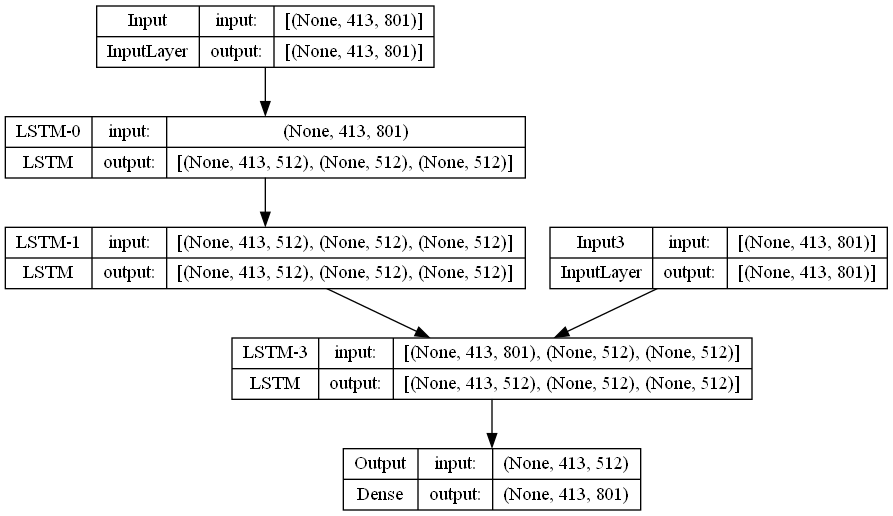

In [34]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

## Training  
we loop over a subset of training data, in order to make training faster.

In [11]:
# set random seeds for reproducability
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [12]:
training_files = np.random.choice(midi_dir, 100)
print(training_files)

['ParkJH05.mid' 'KaszoS07.mid' 'Jussow01.mid' 'Richardson02.mid'
 'Kociuban14.mid' 'ChowK05.mid' 'Savitski09.mid' 'Shamray03.mid'
 'ZhangH06.mid' 'Izzard01.mid' 'Wang08.mid' 'Woo05.mid'
 'PrjevalskayaM10.mid' 'GonzalezJ01.mid' 'Verbaite03.mid' 'Staupe01.mid'
 'WangY02.mid' 'KiselevaD16.mid' 'JohannsonP24.mid' 'Tetzloff08.mid'
 'Shilyaev03.mid' 'BENABD09.mid' 'Tario07.mid' 'JohannsonP24.mid'
 'KaiRuiR08.mid' 'HuangSW06.mid' 'FALIKS01.mid' 'Huang12.mid'
 'GonzalezJ08.mid' 'JeonH06.mid' 'Yeletskiy04.mid' 'BuiJL02.mid'
 'Lee_E03.mid' 'Tsianos02.mid' 'KanM02.mid' 'Wilshire04.mid'
 'Wilshire04.mid' 'Sun02.mid' 'Song05.mid' 'JohannsonP25.mid'
 'ChowK01.mid' 'ZhaoK02.mid' 'Eras01.mid' 'Park09.mid' 'Mizumoto02.mid'
 'KimG06.mid' 'ChernovA22.mid' 'LiYZ08.mid' 'Tysman09.mid' 'YuP04.mid'
 'Falzone02.mid' 'BENABD01.mid' 'SOLOM05.mid' 'Nikiforov01.mid'
 'Avila01.mid' 'Yang03.mid' 'Denisova09.mid' 'KabuliL01.mid'
 'KotysV16.mid' 'Huang12.mid' 'TET01.mid' 'Lee02.mid' 'KiselevaD12.mid'
 'LeeSH14.mid' '

In [13]:
def convertMidiToArray(messages, num_messages = -1, input_size=128*2):
    ret_arr = np.empty((input_size,0), np.int8)
    current_message = 0
    template_vector = np.zeros((input_size,1), np.int8)
    for m in messages:
        if num_messages >= 0 and current_message >= num_messages/3.0:
            break

        if (m.type == "note_on"):
            # add velocity vector
            tmp_vector = template_vector.copy()
            tmp_velocity = int(min(m.velocity/4, 31))
            tmp_vector[128*2+125+tmp_velocity] = 1
            ret_arr = np.hstack((ret_arr, tmp_vector))
            
            # add time shift vector
            tmp_vector = template_vector.copy()
            tmp_vector[128*2+int(min(m.time/8.0, 124))] = 1
            ret_arr = np.hstack((ret_arr, tmp_vector))
            
            # add note vector
            tmp_vector = template_vector.copy()
            tmp_vector[m.note] = 1
            ret_arr = np.hstack((ret_arr, tmp_vector))
            current_message += 1

        
        elif (m.type == "note_off"):
            # add velocity vector
            tmp_vector = template_vector.copy()
            tmp_velocity = int(min(m.velocity/4, 31))
            tmp_vector[128*2+125+tmp_velocity] = 1
            ret_arr = np.hstack((ret_arr, tmp_vector))

            # add time shift vector
            tmp_vector = template_vector.copy()
            tmp_vector[128*2+int(min(m.time/8.0, 124))] = 1
            ret_arr = np.hstack((ret_arr, tmp_vector))
            
            # note off vector
            tmp_vector = template_vector.copy()
            tmp_vector[m.note+128] = 1
            ret_arr = np.hstack((ret_arr, tmp_vector))
            current_message += 1

        
        
    
    return ret_arr.reshape((1, input_size, -1))

In [14]:
training_data = np.empty((0, input_size, num_messages))
for file in training_files:
    tmp = mido.MidiFile(f"midi/{file}")
    
    test_if_valid = np.unique([x.type for x in tmp.tracks[0]])
    if not ("note_on" in test_if_valid and "note_off" in test_if_valid):
        continue
    new_data = convertMidiToArray(tmp.tracks[0], num_messages=num_messages, input_size=input_size)
    print(training_data.shape, new_data.shape)
    if (new_data.shape == (1, input_size, num_messages)):
        training_data = np.vstack((training_data, new_data))

(0, 413, 801) (1, 413, 801)
(1, 413, 801) (1, 413, 801)
(2, 413, 801) (1, 413, 801)
(3, 413, 801) (1, 413, 801)
(4, 413, 801) (1, 413, 801)
(5, 413, 801) (1, 413, 801)
(6, 413, 801) (1, 413, 801)
(7, 413, 801) (1, 413, 801)
(8, 413, 801) (1, 413, 801)
(9, 413, 801) (1, 413, 801)
(10, 413, 801) (1, 413, 801)
(11, 413, 801) (1, 413, 801)
(12, 413, 801) (1, 413, 801)
(13, 413, 801) (1, 413, 801)
(14, 413, 801) (1, 413, 801)
(15, 413, 801) (1, 413, 801)
(16, 413, 801) (1, 413, 801)
(17, 413, 801) (1, 413, 801)
(18, 413, 801) (1, 413, 801)
(19, 413, 801) (1, 413, 801)
(20, 413, 801) (1, 413, 801)
(21, 413, 801) (1, 413, 801)
(22, 413, 801) (1, 413, 801)
(23, 413, 801) (1, 413, 801)
(24, 413, 801) (1, 413, 801)
(25, 413, 801) (1, 413, 801)
(26, 413, 801) (1, 413, 801)
(27, 413, 801) (1, 413, 801)
(28, 413, 801) (1, 413, 801)
(29, 413, 801) (1, 413, 801)
(30, 413, 801) (1, 413, 801)
(31, 413, 801) (1, 413, 801)
(32, 413, 801) (1, 413, 801)
(33, 413, 801) (1, 413, 801)
(34, 413, 801) (1, 413, 

In [15]:
training_data.shape

(91, 413, 801)

In [16]:
target_data = np.zeros(training_data.shape)
target_data[:, :, 0:-1] = training_data[:, :, 1:]

In [17]:
# set random seeds for reproducability
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [18]:
model.fit([training_data, training_data], target_data, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5
2/2 [==============================] - 25s 8s/step - loss: 12.9424 - val_loss: 12.7908
Epoch 2/5
2/2 [==============================] - 20s 7s/step - loss: 13.1102 - val_loss: 14.7992
Epoch 3/5
2/2 [==============================] - 20s 7s/step - loss: 14.7550 - val_loss: 15.5186
Epoch 4/5
2/2 [==============================] - 20s 7s/step - loss: 15.2879 - val_loss: 14.1372
Epoch 5/5
2/2 [==============================] - 21s 7s/step - loss: 14.3633 - val_loss: 16.5405


In [19]:
model.save("test1")

INFO:tensorflow:Assets written to: test1\assets


INFO:tensorflow:Assets written to: test1\assets


## Generating predictions  
Now we can make the model 'predict' in order to make it generate new music.

Relying on Keras documentation examples for code: https://keras.io/examples/nlp/lstm_seq2seq/

In [20]:
model.layers

In [21]:
model = keras.models.load_model("test1")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[1].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(512,))
decoder_state_input_c = keras.Input(shape=(512,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[4]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[5]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [22]:
def decode_sequence(input_seq = np.zeros((1, input_size, num_messages))):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    ret_seq = np.empty((input_size,0), np.int8)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, input_size, num_messages))
    # Populate the first character of target sequence with the start character.
    target_seq[0, np.random.randint(35,100), 0] = 1

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    current_messages = 0
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    ret_seq = output_tokens
    # while not stop_condition:
    #     output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    #     # Sample a token
    #     sampled_token_index = np.argmax(output_tokens[0, -1, :])
    #     current_messages += 1

    #     print(current_messages)
    #     # Exit condition: either hit max length
    #     # or find stop character.
    #     if current_messages > num_messages:
    #         stop_condition = True

    #     # Update the target sequence (of length 1).
    #     target_seq = np.zeros((1, input_size, 1))
    #     target_seq[0, sampled_token_index, 0] = 1

    #     ret_seq = np.hstack((ret_seq, target_seq[0]))

    #     # Update states
    #     states_value = [h, c]
    return ret_seq

In [23]:
# set random seeds for reproducability
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [24]:
output_sequence = decode_sequence()

1/1 [==============================] - 0s 485ms/step


In [25]:
print(output_sequence.shape)

(1, 413, 801)


## Exporting  
Now we have to convert the output back to the midi file.

In [26]:
def convertArrayToMidi(arr, filename = None):
    ret_file = mido.MidiFile(type=0) # create empty midi file
    track = mido.MidiTrack()
    ret_file.tracks.append(track)

    # track.append(mido.Message('program_change', program=12, time=0))
    time = 0
    prev_was_time_event = True
    velocity = 64
    for col in range(arr.shape[-1]):
        tmp_col = arr[:, col]
        tmp_note = np.argmax(tmp_col)

        if tmp_note < 128: # note on event
            if not (prev_was_time_event):
                time = 32
                print("no time")
            track.append(mido.Message('note_on', note=tmp_note, velocity=velocity, time=time))
            time = 0
            prev_was_time_event = False
        
        elif tmp_note >= 128 and tmp_note < 128*2: # note off event
            if not (prev_was_time_event):
                print("no time")
                time = 32
            track.append(mido.Message('note_off', note=tmp_note-128, velocity=velocity, time=time))
            time = 0
            prev_was_time_event = False

        elif tmp_note >= 128*2 and tmp_note < 128*2+125: # time shift event
            time += int((tmp_note-128*2)*8*2)
            prev_was_time_event = True
        
        else: # velocity event
            velocity = int(min((tmp_note-128*2-125)*4, 127))
        
    

    if (filename is not None):
        ret_file.save(filename)
    
    return ret_file

In [27]:
ret_midi = convertArrayToMidi(output_sequence[0], "test1.mid")
ret_midi.ticks_per_beat = mido.MidiFile(f'midi/{training_files[0]}').ticks_per_beat
ret_midi.save("test1.mid")

no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time


In [28]:
ret_midi

MidiFile(type=0, ticks_per_beat=384, tracks=[
  MidiTrack([
    Message('note_on', channel=0, note=0, velocity=64, time=0),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=1, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=1, velocity=64, time=32),
    Message('note_on', channel=0, note=2, velocity=64, time=32),
    Message('note_on', channel=0, note=7, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=3, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=1, velocity=64, time=32),
    Message('note_on', channel=

In [29]:
convertArrayToMidi(training_data[0], "ParkJH05 decoded.mid")

MidiFile(type=0, ticks_per_beat=480, tracks=[
  MidiTrack([
    Message('note_on', channel=0, note=70, velocity=44, time=160),
    Message('note_on', channel=0, note=50, velocity=24, time=0),
    Message('note_on', channel=0, note=58, velocity=32, time=0),
    Message('note_off', channel=0, note=58, velocity=52, time=272),
    Message('note_off', channel=0, note=50, velocity=36, time=464),
    Message('note_on', channel=0, note=72, velocity=60, time=16),
    Message('note_off', channel=0, note=70, velocity=52, time=0),
    Message('note_on', channel=0, note=60, velocity=20, time=48),
    Message('note_on', channel=0, note=53, velocity=36, time=0),
    Message('note_off', channel=0, note=60, velocity=44, time=208),
    Message('note_off', channel=0, note=53, velocity=48, time=256),
    Message('note_on', channel=0, note=58, velocity=32, time=64),
    Message('note_on', channel=0, note=74, velocity=68, time=16),
    Message('note_on', channel=0, note=46, velocity=36, time=0),
    Message

In [31]:
a = np.random.rand(input_size, num_messages)
b = np.zeros_like(a)
b[np.arange(len(a)), a.argmax(1)] = 1
convertArrayToMidi(b, "random.mid")

no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time
no time


MidiFile(type=0, ticks_per_beat=480, tracks=[
  MidiTrack([
    Message('note_off', channel=0, note=127, velocity=64, time=0),
    Message('note_on', channel=0, note=20, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=1552),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=1008),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_off', channel=0, note=65, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on', channel=0, note=0, velocity=64, time=32),
    Message('note_on'